## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

## Importing the preprocessed data

In [2]:
# We already cleaned and preprocessed the data:

df = pd.read_csv("C:/Users/hadip/Downloads/Portfolio/half_marathon/data/cleaned_half_marathon_data.csv")
df.head()

,TEMPO_REALE_SECONDS,ANNO,2025_km,5K_PB,log_total_km,SESSO_M
0,7664.0,1997,40.0,1723.0,5.869297,0
1,8163.0,1986,41.0,1598.0,4.634729,1
2,6080.0,1993,44.0,1299.0,5.768321,1
3,7653.0,2001,109.0,1649.0,4.691348,1
4,6984.0,1995,133.0,1475.0,5.093750,1


## Regression

### Define inputs and target

In [3]:


x = df.drop(columns=['TEMPO_REALE_SECONDS']) 
y = df["TEMPO_REALE_SECONDS"]

### Scaling the data

In [5]:
scaler = StandardScaler()
scaler.fit(x)

StandardScaler()

In [6]:
x_scaled = scaler.transform(x)

In [7]:
# Split the data into train and test sets.

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=5)

In [40]:
# Creating and fitting the random forrest model

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

### Model performance

In [42]:
# Training and test predictions

y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)

# R² Scores

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train R²: {r2_train:.3f}")
print(f"Test R²: {r2_test:.3f}")


Train R²: 0.967
Test R²: 0.755


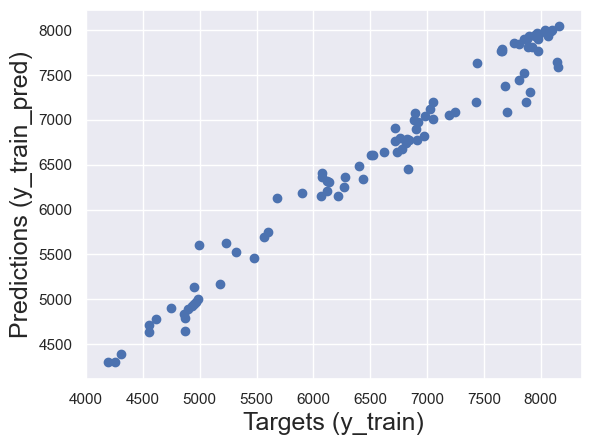

In [44]:
# To compare the targets (y_train) and the predictions (y_train_pred), we plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction

plt.scatter(y_train, y_train_pred)

plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_train_pred)',size=18)
plt.show()

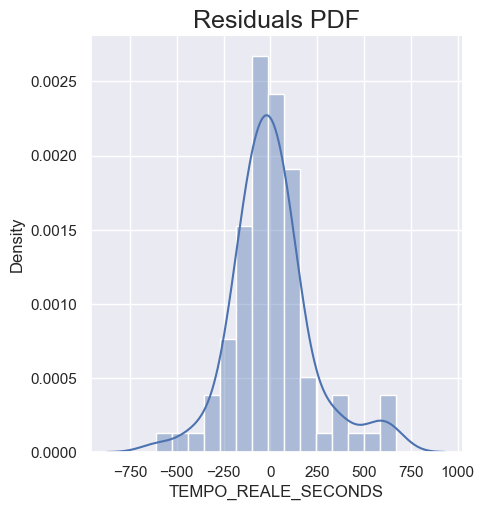

In [46]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies

sns.displot(y_train - y_train_pred,  kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4)
plt.title("Residuals PDF", size=18)

# In the best case scenario this plot should be normally distributed

# Given the definition of the residuals (y_train - y_train_pred), negative values imply
# that y_train_pred (predictions) are much higher than y_train (the targets), i.e., some kind of over estimation of the values by the model.

plt.show()

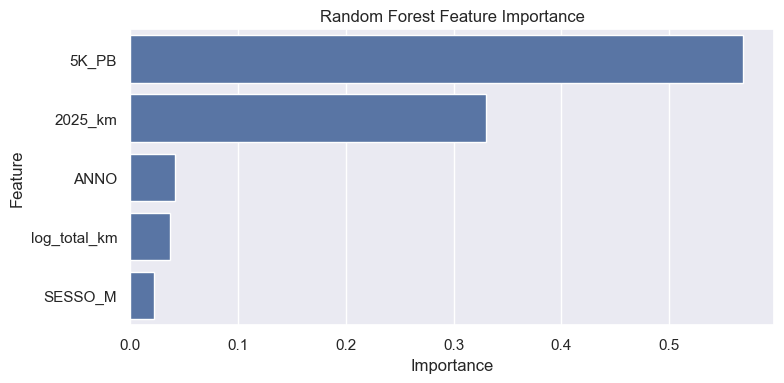

In [52]:
# In a Random Forest, feature importance is usually calculated based on how much each feature decreases the 
# impurity (like mean squared error for regression) across all the trees in the forest.

importances = rf.feature_importances_
features = x.columns

# Create a DataFrame
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

### Testing

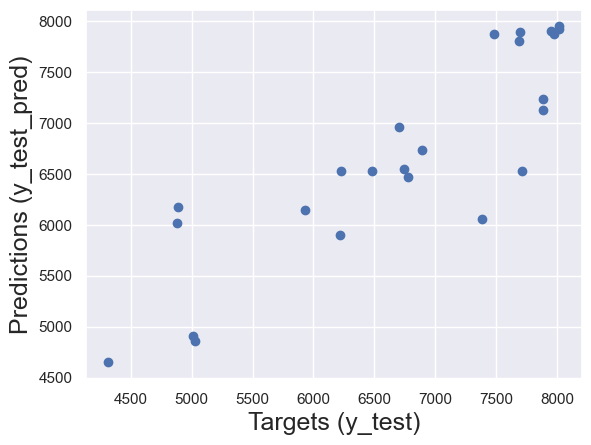

In [14]:
# To compare the targets (y_test) and the predictions (y_test_pred), we plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_test, y_test_pred)

plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_test_pred)',size=18)
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same
plt.show()

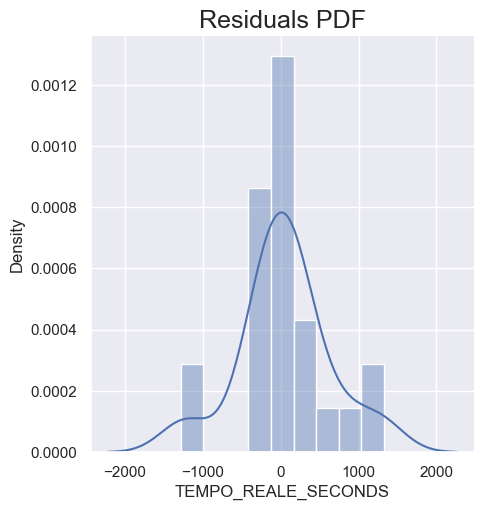

In [15]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.displot(y_test - y_test_pred,  kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4)

plt.title("Residuals PDF", size=18)

# In the best case scenario this plot should be normally distributed

# Given the definition of the residuals (y_train - y_train_pred), negative values imply
# that y_train_pred (predictions) are much higher than y_train (the targets), i.e., some kind of over estimation of the values by the model.

plt.show()

In [16]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, x_scaled, y, cv=kf, scoring='r2')

print(f"CV R² Scores: {cv_scores}")
print(f"Average CV R²: {cv_scores.mean():.3f}")

CV R² Scores: [0.65023804 0.61094109 0.82383086 0.80641561 0.82588176]
Average CV R²: 0.743


In [17]:
# Considering the gap between train and test R2, the model is probably overfitting the training data,
# therefore we would be better off playing aruond with some hyperparameters of the random forrest model
# to mitigate this effect.
# For that purpose, we might want to run a paramter grid search!

## Model optimization

In [18]:
# We'll define a grid to be searched.

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

In [19]:
# Run it using the predefined grid and a random forrest applied with all the possible alternatives.

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5],
                         'n_estimators': [100, 200]},
             scoring='r2')

### Running and evaluating the best model

In [20]:
# Evaluate the best model

best_model = grid_search.best_estimator_

train_r2 = best_model.score(x_train, y_train)
test_r2 = best_model.score(x_test, y_test)
print(f"Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}")

Train R²: 0.966, Test R²: 0.803


In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, x_scaled, y, cv=kf, scoring='r2')

print(f"CV R² Scores: {cv_scores}")
print(f"Average CV R²: {cv_scores.mean():.3f}")

CV R² Scores: [0.7322606  0.64225013 0.79023214 0.80955122 0.80203853]
Average CV R²: 0.755


In [22]:
# Based on the fact that the distance between the train and test R2 has decreased plus the average R2 scores across the 5 
# folds have also increased, we conclude that the "best_model" is the way to go forward.
# Therefore we will be printing its hyperparameters and look at the scatter and residual plots below.

# parameters of the best random forrest model

grid_search.best_params_

{'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 200}

In [23]:
# Parameters of the original regular default random forrest model

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

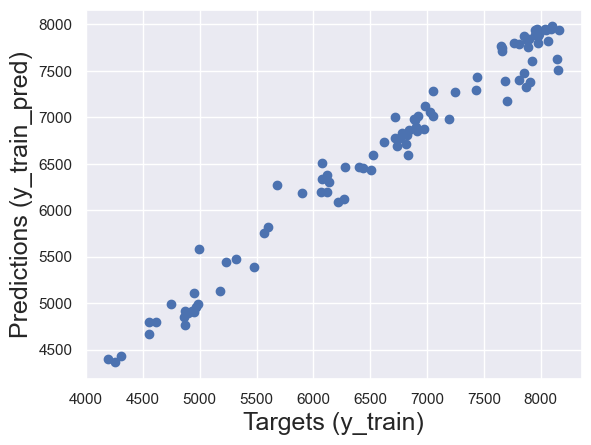

In [24]:
# Let's look at the plots of the training and testing sets using the new best model!


# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, best_model.predict(x_train))

plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_train_pred)',size=18)
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same
plt.show()

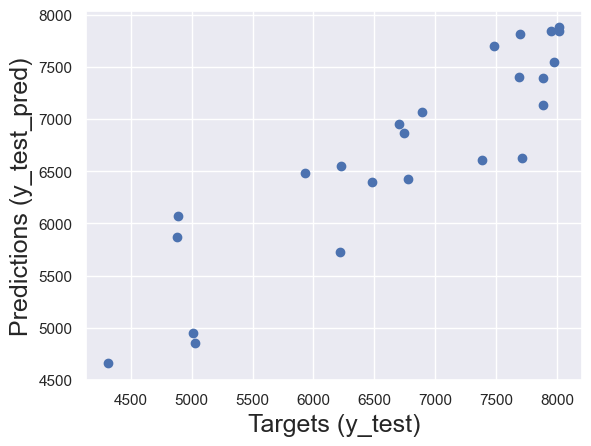

In [25]:

# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_test, best_model.predict(x_test))

plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_test_pred)',size=18)

# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same
plt.show()

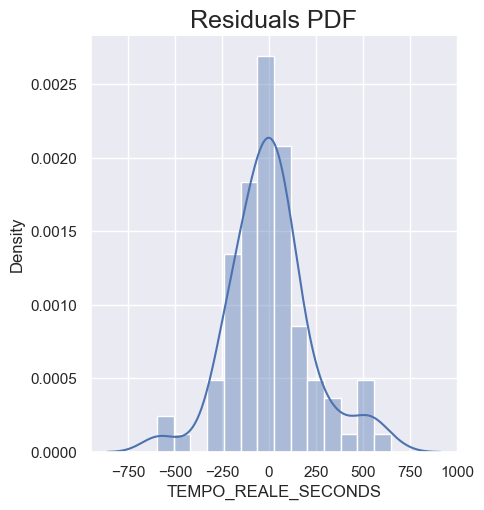

In [26]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.displot(y_train - best_model.predict(x_train),  kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4)

plt.title("Residuals PDF", size=18)

# In the best case scenario this plot should be normally distributed

# Given the definition of the residuals (y_train - y_train_pred), negative values imply
# that y_train_pred (predictions) are much higher than y_train (the targets), i.e., some kind of over estimation of the values by the model.

plt.show()

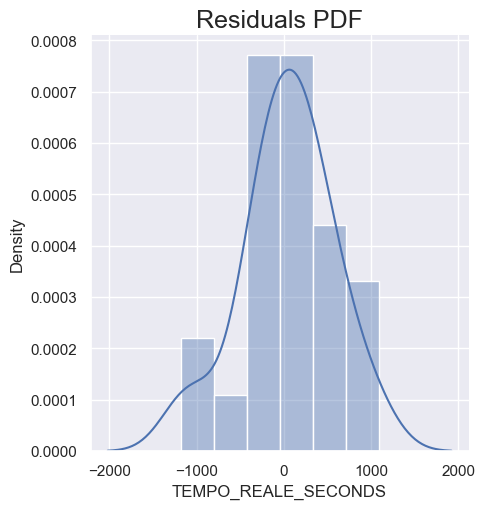

In [27]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies.

sns.displot(y_test - best_model.predict(x_test),  kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4)

plt.title("Residuals PDF", size=18)

# In the best case scenario this plot should be normally distributed

# Given the definition of the residuals (y_train - y_train_pred), negative values imply
# that y_train_pred (predictions) are much higher than y_train (the targets), i.e., some kind of over estimation of the values by the model.

plt.show()

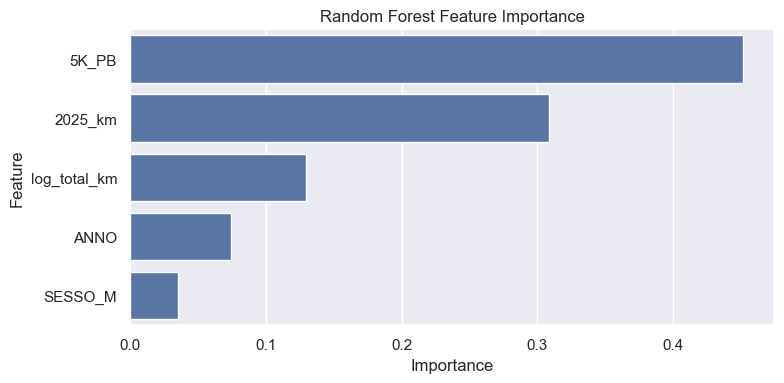

In [36]:
importances = best_model.feature_importances_
features = x.columns

# Create a DataFrame
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

In [29]:
# Altogether, both the scatter and the residual plots "look" better with the "best" model.

In [30]:
y_test = y_test.reset_index(drop=True)

In [31]:
df_pf = pd.DataFrame(best_model.predict(x_test), columns=['Prediction'])
df_pf['Target'] = y_test
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf

,Prediction,Target,Residual,Difference%
0,7839.16,7946.00,106.84,1.34
1,7130.73,7882.00,751.27,9.53
2,5727.25,6221.00,493.75,7.94
3,7819.14,7696.00,-123.14,1.60
4,7877.17,8015.00,137.83,1.72
5,7839.24,8017.00,177.76,2.22
6,4948.42,5008.00,59.58,1.19
7,7545.42,7977.00,431.58,5.41
8,6484.88,5932.00,-552.88,9.32
9,7395.39,7885.00,489.61,6.21


In [32]:
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,24.00,24.00,24.00,24.00
mean,6694.16,6739.92,45.75,6.40
std,961.34,1190.26,526.29,6.01
min,4657.32,4316.00,-1183.28,1.19
25%,6315.10,6148.75,-222.92,2.13
50%,6747.53,6833.50,93.74,4.52
75%,7437.53,7756.75,372.27,8.28
max,7877.17,8017.00,1086.88,24.21


In [64]:
# The conlcusion is that althought we get a better R2 and CV R2, the average percentage error regarding the 
# predicted times are higher in the random forrest model. This, plus the relative simplicity in the simple
# linear regression analysis and the insight provided by the weights of the different regressors, convinced us 
# to go forward with the linear regression model and present the rest of the analyses as exploratory and confirmatory.